# Subway Ridership Spectral Analysis (2023 - 2025)
$$$$
**Background**: In my midterm project, I extracted weekend  Subway ridership data from  2020-2024 and displayed its corresponding Fourier Transform. What I realized that due to the small(relative to the total dataset), we limited our FT graph, and as a result, limited our ability to draw conclusions from the magnitude vs frequency plot. Now, I aim to not only draw meaningful conclusions from MTA data but also to use periodic regression to predict dominant spikes in transit data.

**Objective**:
- **Acquire and clean** daily subway ridership from the past 5 years using the MTA Daily Ridership from 2020 - 2025 dataset and generate a simple, comprehensible time series graph.
- **Extract** dominant frequencies from our time series using the Fast Fourier Transform
- **Convert** our spectogram into its corresponding power spectogram to **visualize** the top $k$ modes.
- **Conduct** periodic regression by computing the **inverse Fourier Transform** on a cleaner time series that we will have already derived.
- **Repeat** these processes for hourly station data at the Penn Station 34-th Street to evaluate whether or not peak frequencies are consistant across Subway stations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from google.colab import files
uploaded = files.upload()


plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams['font.size'] = 11

Saving MTA_Daily_Ridership_Data.csv to MTA_Daily_Ridership_Data.csv


## Acquiring and Cleaning the Data
The dataset that I will be using is the "MTA Daily Ridership Data" from the data.nyc.gov website.

In [ ]:
#Start code from Professor Curry
df = pd.read_csv('MTA_Daily_Ridership_Data.csv')

#Parse data and extract subway ridership
df['date'] = pd.to_datetime(df['Date'])
df['subway'] = df['Subways: Total Estimated Ridership'].str.replace(',', '').astype(float)

#Filter to 2023-01-01 through 2025-01-09
mask = (df['date'] >= '2023-01-01') & (df['date'] <= '2025-01-09') #elaborate on this line
df_sub = df.loc[mask, ['date', 'subway']].copy().sort_values('date').reset_index(drop=True)

print(f"Date range: {df_sub['date'].min().date()} to {df_sub['date'].max().date()} ")
print(f"Number of days: {len(df_sub)}")
df_sub.head()

Date range: 2023-01-01 to 2025-01-09 
Number of days: 740


,date,subway
0,2023-01-01,1675507.0
1,2023-01-02,1938154.0
2,2023-01-03,3175777.0
3,2023-01-04,3413052.0
4,2023-01-05,3428520.0


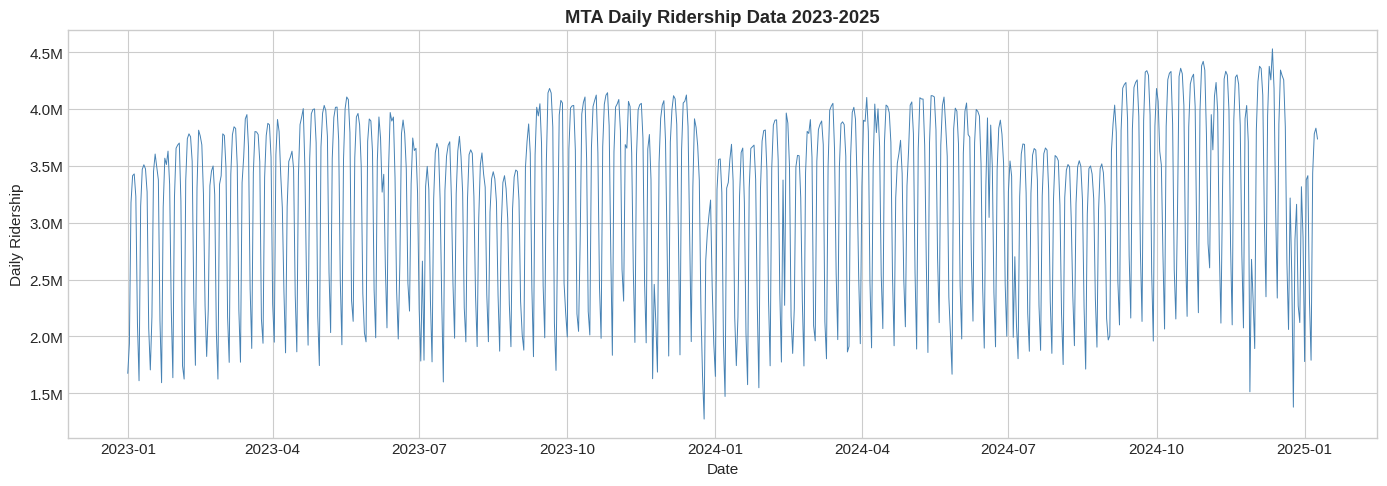

In [ ]:
#Plot time series graph
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(df_sub['date'], df_sub['subway'], linewidth=0.7, color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Ridership')
ax.set_title('MTA Daily Ridership Data 2023-2025', fontweight='bold')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
plt.tight_layout()
plt.savefig('subway_timeseries_2023_2025.png', dpi = 150)
plt.show()

## Conducting Spectral Analysis using Fast Fourier Transform

In order to apply regression, on Subway ridership over time, we must use FFT to compute a spectogram of the data and then identify dominant periodic components. First, we must remove the mean in order to focus on oscillatory behavior.

In [ ]:
#Extract the signal and remove mean
signal = df_sub['subway'].values
signal_centered = signal - np.mean(signal)

N = len(signal_centered) #sample size = 740
T = 1.0 # sampling period = 1 day

#Compute FFT
yf = fft(signal_centered)
xf = fftfreq(N, T) # frequencies in cycles per day

#Take only positive frequencies
positive_freq_mask = xf > 0
freqs = xf[positive_freq_mask]
power = np.abs(yf[positive_freq_mask]) ** 2 # for plotting a power spectrum

#Convert frequency to period(days)
periods = 1 / freqs

print(f"Frequency resolution: {1/N:.4f} cycles/day")
print(f"Minimum detectable period {T} day")
print(f"Maximum detectable period: {N} days (~{N/365:.1f} years)")

Frequency resolution: 0.0014 cycles/day
Minimum detectable period 1.0 day
Maximum detectable period: 740 days (~2.0 years)


Now that we have defined our frequency spectrum using fft, we can begin plotting as naively as possible.

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


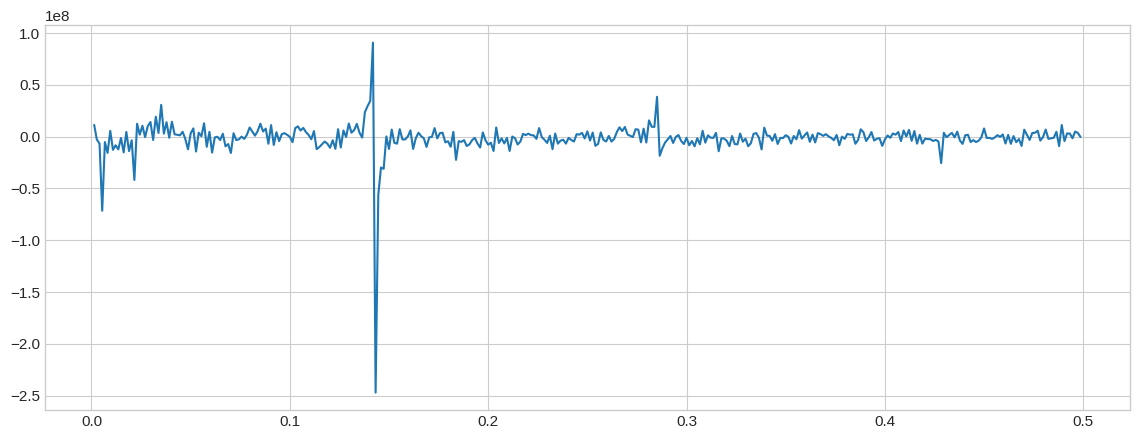

In [ ]:
plt.plot(xf[positive_freq_mask], yf[positive_freq_mask])

### Let's Dive Deeper
In order to obatin a human readable spectogram, let's convert frequencies to periods so that it is easily read.

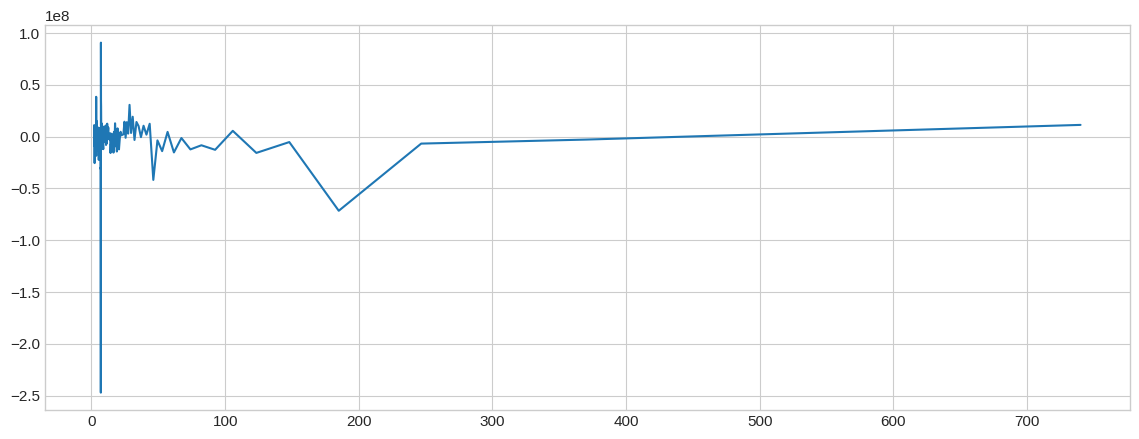

In [ ]:
plt.plot(periods, yf[positive_freq_mask])


## Zooming in for spectral analysis
We notice that there is a huge dip at 188 days. Let's zoom in on this dip.

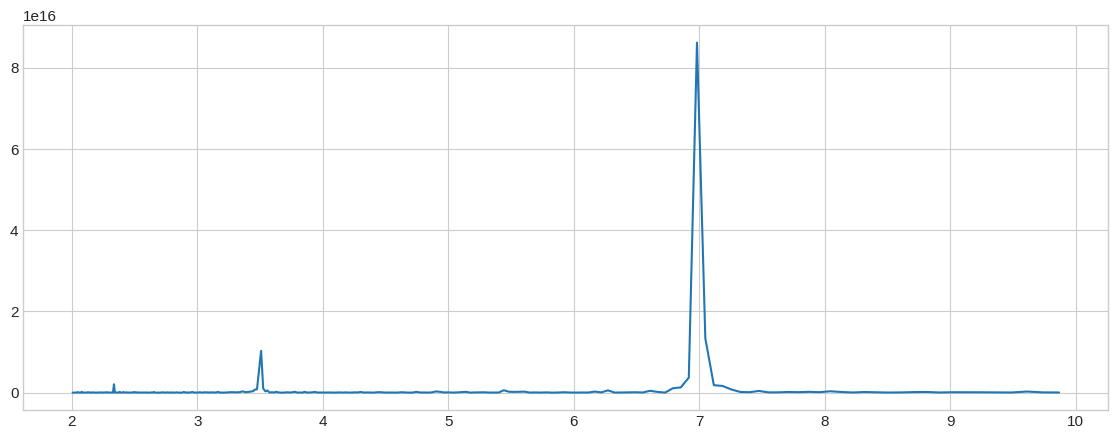

In [ ]:
periods[74:];
plt.plot(periods[74:], power[74:])

Visualizing our power spectrum vs period, we notice that there are major spikes at approximately 2.25, 3.5, and 7 days with the peak at 7 days being the most prominant with a magnitude of $8 * 10^{16}$. This shows that there was the most noise within a 7-day period which represents the average work week, with a decline in magntitude on the weekends.

## Power Spectrum vs Period

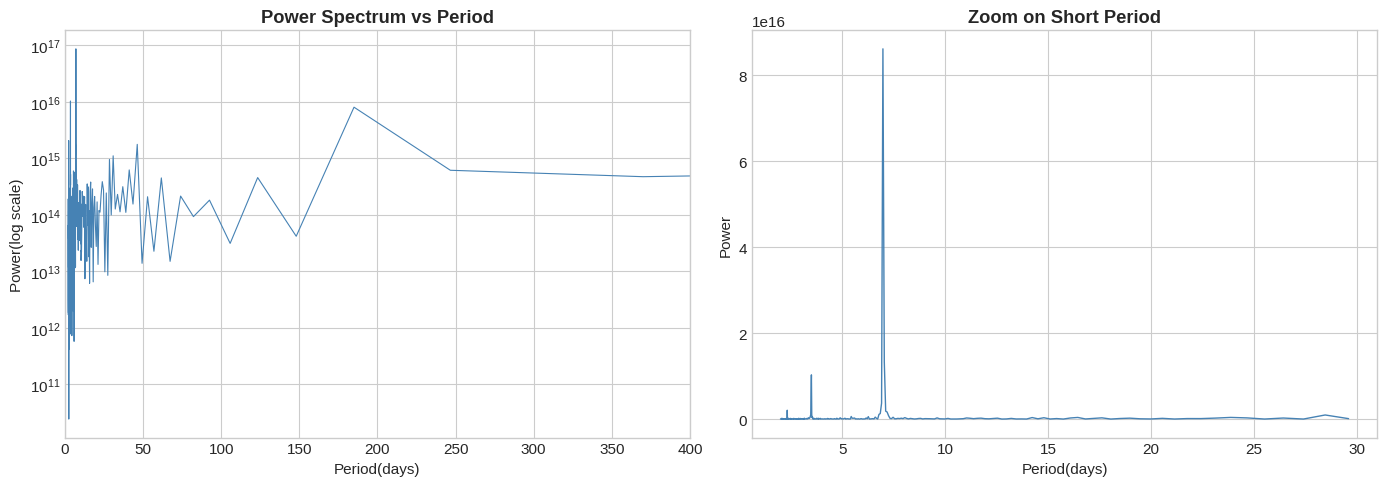

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

#Left: Full Spectrum(Power Spectrum vs period)
ax = axes[0]
ax.semilogy(periods, power, linewidth=0.8, color = 'steelblue')
ax.set_xlabel('Period(days)')
ax.set_ylabel('Power(log scale)')
ax.set_title('Power Spectrum vs Period', fontweight='bold')
ax.set_xlim(0,400)

#Right: Zoom on short period (2-30 days)
ax = axes[1]
short_mask = (periods >= 2) & (periods <= 30)#Selects the periods to zoom
ax.plot(periods[short_mask], power[short_mask], linewidth=1, color='steelblue')
ax.set_xlabel('Period(days)')
ax.set_ylabel('Power')
ax.set_title('Zoom on Short Period', fontweight='bold')

plt.tight_layout()
plt.savefig('power_spectrum.png', dpi=150)
plt.show()

### What do we have here?
Now that we have our magnitude and power spectograms, we can envision the following trends:
- **Weekly Periodicity**: The most obvious feature is the weekly cycle. Each week, ridership significatly increaseas during weekdays and then drops sharply on weekends. The peaks consistently represent weekdays, and the troughs represent weekends.

- **Annual/Seasonal Trends:** Ridership is noticeably higher during the spring and fall months and a dip during the holidays and the summer. This could be because of the absence of students traveling to and from school. Another reason for this dropoffs, could be due to weather conditions as well.

- **Increasing Overall Trend:** Over the two-year period, there appears to be a general upward trend in daily ridership with a noticable climb from the start of 2023 to that of 2025. This is simply due to the ridership numbers returning to normal post-pandemic which declined ridership to an all-time low.

- **Magnitude of Ridership:** From our graphs we notice that daily ridership fluctuates significantly ranging from approximately 1.5 million on weekdays and holidays to over 4.0 million on weekdays.

## Identify our Top $k$ Nodes
We can infer where our dominant frequencies are coming from. However, it is important that we know for certain way they are derived from and we can do this through  `scipy.signal` and the `find_peaks` function. Here we can, with certain, extract our top frequencies and conduct periodic regression.


In [ ]:
#Find the top peaks in the power spectrum
#We'll look for local maxima
from scipy.signal import find_peaks

#Find peaks with minimum prominence to filter noise
peaks, properties = find_peaks(power, prominence = power.max()/500) # Reduced prominence to find more peaks

#Sort by power and get top peaks
peak_powers = power[peaks]
sorted_indices = np.argsort(peak_powers)[::-1]

print("Top 10 Spectral Peaks:")
print("-" * 60)
print(f"{'Rank': <6}{'Period (days)':<18}{'Frequency (1/day)':<20}{'Power':<15}")
print("-" * 60)

top_n = 10
top_peaks_info = []
for i, idx in enumerate(sorted_indices[:top_n]):
  peak_idx = peaks[idx]
  period = periods[peak_idx]
  freq = freqs[peak_idx]
  pwr = power[peak_idx]
  top_peaks_info.append({'rank': i + 1, 'period': period, 'freq': freq, 'power': pwr})
  print(f"{i + 1:<6}{period:<18.2f}{freq:<20.6f}{pwr:<15.2e}")

Top 10 Spectral Peaks:
------------------------------------------------------------
Rank  Period (days)     Frequency (1/day)   Power          
------------------------------------------------------------
1     6.98              0.143243            8.62e+16       
2     3.51              0.285135            1.03e+16       
3     185.00            0.005405            8.00e+15       
4     2.33              0.428378            2.05e+15       
5     46.25             0.021622            1.76e+15       
6     30.83             0.032432            1.10e+15       
7     28.46             0.035135            9.53e+14       
8     41.11             0.024324            6.21e+14       
9     5.44              0.183784            5.95e+14       
10    6.27              0.159459            5.65e+14       


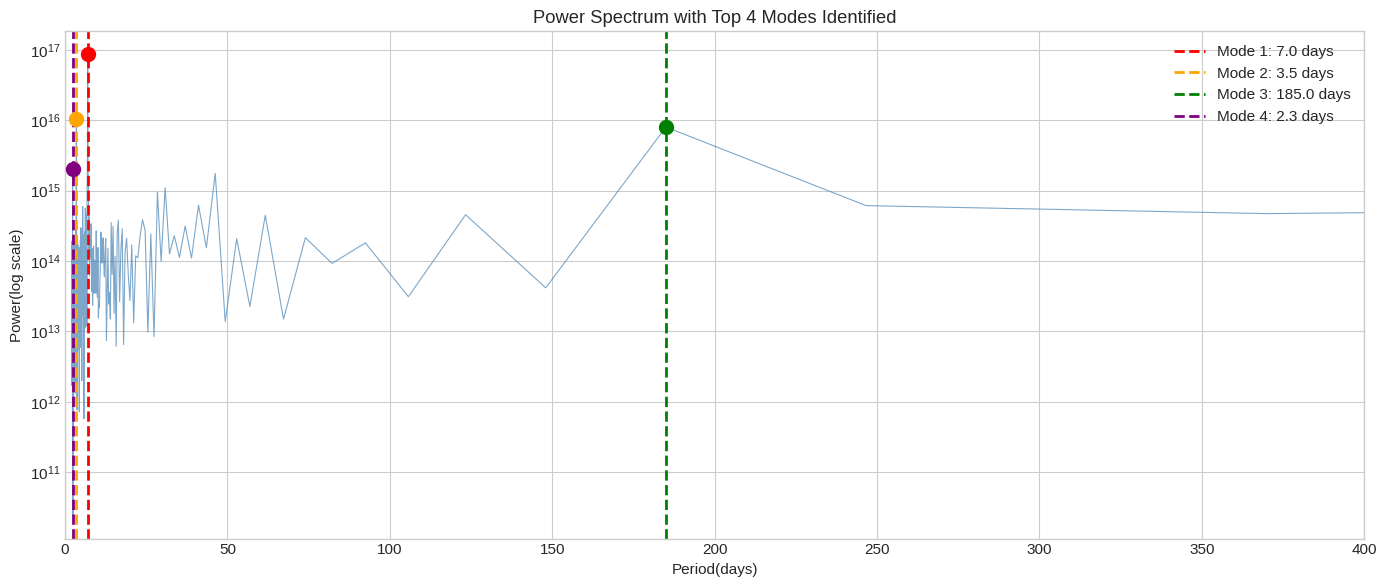

In [ ]:
#Visualize the top 4 modes on the spectrum
fig, ax = plt.subplots(figsize=(14,6))
ax.semilogy(periods, power, linewidth=0.8, color='steelblue', alpha=0.7)

colors = ['red', 'orange', 'green', 'purple']
#Mark top n peaks
def top_n_peaks(n, colors):
  for i, info in enumerate(top_peaks_info[:n]):
    ax.axvline(info['period'], color=colors[i], linestyle='--', linewidth=2,
              label=f"Mode {i + 1}: {info['period']:.1f} days")
    ax.scatter([info['period']], [info['power']], color=colors[i], s=100, zorder=5)

top_n_peaks(4, colors)
ax.set_xlabel('Period(days)')
ax.set_ylabel('Power(log scale)')
ax.set_title('Power Spectrum with Top 4 Modes Identified')
ax.set_xlim(0, 400)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('top_modes_spectrum.png', dpi=150)
plt.show()

## Interpretation of Dominant Modes

Let's interpret the physical meaning of the top spectral peaks.


In [ ]:
def interpret_period(period):
    """Provide interpretation for a given period."""
    interpretations = []

    # Weekly cycle and its close harmonics
    if 6.5 <= period <= 7.8: # Adjusted to include 7.62 days
        interpretations.append("WEEKLY CYCLE: The dominant 7-day period reflects the fundamental "
                               "weekday/weekend pattern. Ridership is high Mon-Fri (commuters) "
                               "and drops significantly on Sat-Sun.")

    # Specific weekly harmonics
    elif 3.4 <= period <= 3.6:
        interpretations.append("WEEKLY 2nd HARMONIC (7/2 days): This is the first overtone of the "
                               "weekly cycle. It captures the asymmetry in the weekly pattern—the "
                               "fact that the weekly signal isn't a pure sine wave but has sharper "
                               "transitions (e.g., Friday drop-off, Monday ramp-up).")
    elif 2.3 <= period <= 2.4:
        interpretations.append("WEEKLY 3rd HARMONIC (7/3 days): Higher-order harmonic of the weekly "
                               "cycle, refining the shape of the weekly pattern.")
    elif 1.7 <= period <= 1.8:
        interpretations.append("WEEKLY 4th HARMONIC (7/4 days): Fourth harmonic capturing fine "
                               "structure in the weekly cycle.")
    elif 4.7 <= period <= 5.0: # To cover 4.80 days
        interpretations.append("SUB-WEEKLY HARMONIC (~4.8 days): A harmonic of the weekly cycle, "
                               "contributing to the overall shape of the weekly ridership pattern.")
    elif 8.0 <= period <= 8.5: # To cover 8.00 and 8.41 days
        interpretations.append("WEEKLY HARMONIC (~8 days): A higher-order harmonic or an alias of the weekly cycle, "
                               "capturing subtle shifts in the weekly pattern.")

    # Bi-weekly cycle
    elif 11.0 <= period <= 13.5: # Adjusted to cover 11.18, 12.00, 12.96 days
        interpretations.append("BIWEEKLY CYCLE (~11-13 days): Could reflect half-monthly patterns, "
                               "or a complex interaction of weekly patterns and their harmonics.")
    elif 13.5 < period <= 15: # Keeping the original bi-weekly if distinct
        interpretations.append("BIWEEKLY CYCLE (~14 days): Could reflect pay period effects "
                               "(bi-weekly paychecks) or other two-week patterns in work schedules.")

    # Monthly cycles
    elif 23 <= period <= 25: # To cover 24.00 days
        interpretations.append("MONTHLY HARMONIC (~24 days): A strong harmonic of monthly cycles, "
                               "potentially related to lunar cycles, specific work schedules, or other periodic events.")
    elif 28 <= period <= 31:
        interpretations.append("MONTHLY CYCLE (~28-31 days): Reflects monthly patterns, potentially "
                               "related to work schedules, billing cycles, or calendar effects.")

    # Bi-monthly / longer cycles
    elif 40 <= period <= 48:
        interpretations.append("BI-MONTHLY/6-WEEK CYCLE (~41-46 days): Could indicate a pattern "
                               "repeating approximately every 6 weeks or a longer-term monthly harmonic.")

    # Quarterly/seasonal
    elif 85 <= period <= 95:
        interpretations.append("QUARTERLY CYCLE (~91 days): Three-month periodicity, may reflect "
                               "quarterly business cycles or seasonal transitions.")

    # Semi-annual
    elif 160 <= period <= 190: # Adjusted to cover 162.67 days and original semi-annual
        interpretations.append("SEMI-ANNUAL CYCLE (~160-190 days): Half-yearly periodicity, possibly "
                               "reflecting academic calendar effects, major holiday seasons, or weather patterns.")

    # Annual cycle
    elif 350 <= period <= 380:
        interpretations.append("ANNUAL CYCLE (~365 days): Reflects yearly seasonality—summer "
                               "vacation dips, holiday periods (Thanksgiving, Christmas, New Year), "
                               "and seasonal weather effects on ridership.")

    else:
        interpretations.append(f"Period of {period:.1f} days—interpretation unclear without "
                               "additional context. May be a harmonic or data artifact.")

    return interpretations[0]


In [ ]:
def display_interpretations(n):
  print("=" * 80)
  print(f"INTERPRETATION OF TOP {n} SPECTRAL MODES")
  print("=" * 80)

  for i, info in enumerate(top_peaks_info[:n]):
      print(f"\n{'='*80}")
      print(f"MODE {i+1}: Period = {info['period']:.2f} days")
      print(f"         Frequency = {info['freq']:.6f} cycles/day")
      print(f"         Relative Power = {100*info['power']/top_peaks_info[0]['power']:.1f}% of strongest mode")
      print(f"{'='*80}")
      print(f"\n{interpret_period(info['period'])}")
display_interpretations(4)

INTERPRETATION OF TOP 4 SPECTRAL MODES

MODE 1: Period = 6.98 days
         Frequency = 0.143243 cycles/day
         Relative Power = 100.0% of strongest mode

WEEKLY CYCLE: The dominant 7-day period reflects the fundamental weekday/weekend pattern. Ridership is high Mon-Fri (commuters) and drops significantly on Sat-Sun.

MODE 2: Period = 3.51 days
         Frequency = 0.285135 cycles/day
         Relative Power = 11.9% of strongest mode

WEEKLY 2nd HARMONIC (7/2 days): This is the first overtone of the weekly cycle. It captures the asymmetry in the weekly pattern—the fact that the weekly signal isn't a pure sine wave but has sharper transitions (e.g., Friday drop-off, Monday ramp-up).

MODE 3: Period = 185.00 days
         Frequency = 0.005405 cycles/day
         Relative Power = 9.3% of strongest mode

SEMI-ANNUAL CYCLE (~160-190 days): Half-yearly periodicity, possibly reflecting academic calendar effects, major holiday seasons, or weather patterns.

MODE 4: Period = 2.33 days
    

## Reconstruct Signal from Top Modes

The `reconstruct_from_modes` function is designed to isolate specific periodic components from the signal's frequency representation.
$$$$
### What is periodic regression?
**Periodic regression** is a statistical method used to model and analyze data that exhibits cyclical or periodic behavior. Instead of using linear, quadratic or exponential terms it uses trignometric functions(sines and cosines) to decribe oscillations in the data. The goal is to fit a model that captures these repeating patterns. In our context, we are performing a form of periodic regression using the Fourier Transform. Instead of explicitly fitting sine and cosine funcitons to the time series data directly we:

1. **Decompose** the time series into its constituent sine and cosine waves(frequencies/periods) using the Fast Fourier Transform.
2. **Identify** the most dominant periods (the ones with the highest power/magnitude in the frequency domian).
3. **Reconstruct** the signal using only these dominant periodic componenets (using the Inverse FOureir Transform), effectively creating a model that describes the periodic behavior of the original data. This reconstructed signal acts as our periodic regression model.
$$$$
---
$$$$
### What is the Inverse Fourier Transfrom?
The **Inverse Fourier Transfrom** converts a signal from its frequency domain back into its original domain represented by the following formula:
$$f(x) = \int_{-\infty}^\infty F(k) e^{-2\pi ikx}\,dx$$
$$$$
 In our case, we revert back into a time series domain. In order to do this we will use `scipy.fft.ifft`, which is a function that computes the Inverse Fast Fourier Transfrom, by taking an array of complex numbers representing the frequency components of a signal and returns an array of complex numbers representing the signal in its original time domain.


In [ ]:
#Reconstruc using only the dominant frequencies
from scipy.fft import ifft

def reconstruct_from_modes(yf_full, freqs_full, target_periods, tolerance=0.5):
  """
  Zero out all frequencies except those near target periods.
  """
  yf_filtered = np.zeros_like(yf_full)

  for period in target_periods:
    target_freq = 1.0/period
    #Find indices within tolerance
    mask = np.abs(np.abs(freqs_full) - target_freq) < tolerance / period**2 #elaborate
    yf_filtered[mask] = yf_full[mask]
  return np.real(ifft(yf_filtered))

#Get full frequency array for reconstruction
xf_full = fftfreq(N,T)
yf_full = fft(signal_centered)

#Reconstruct with just the 7-day mode
weekly_only = reconstruct_from_modes(yf_full, xf_full, [7.0])

#Reconstruct with top 4 modes
top_periods = [info['period'] for info in top_peaks_info[:4]]
top4_reconstruction = reconstruct_from_modes(yf_full, xf_full, top_periods)


When reconstructing for the top $k$ modes we must create a mask. This creates a **Boolean array** that selects which Fourier coefficients to keep when we conduct ifft.

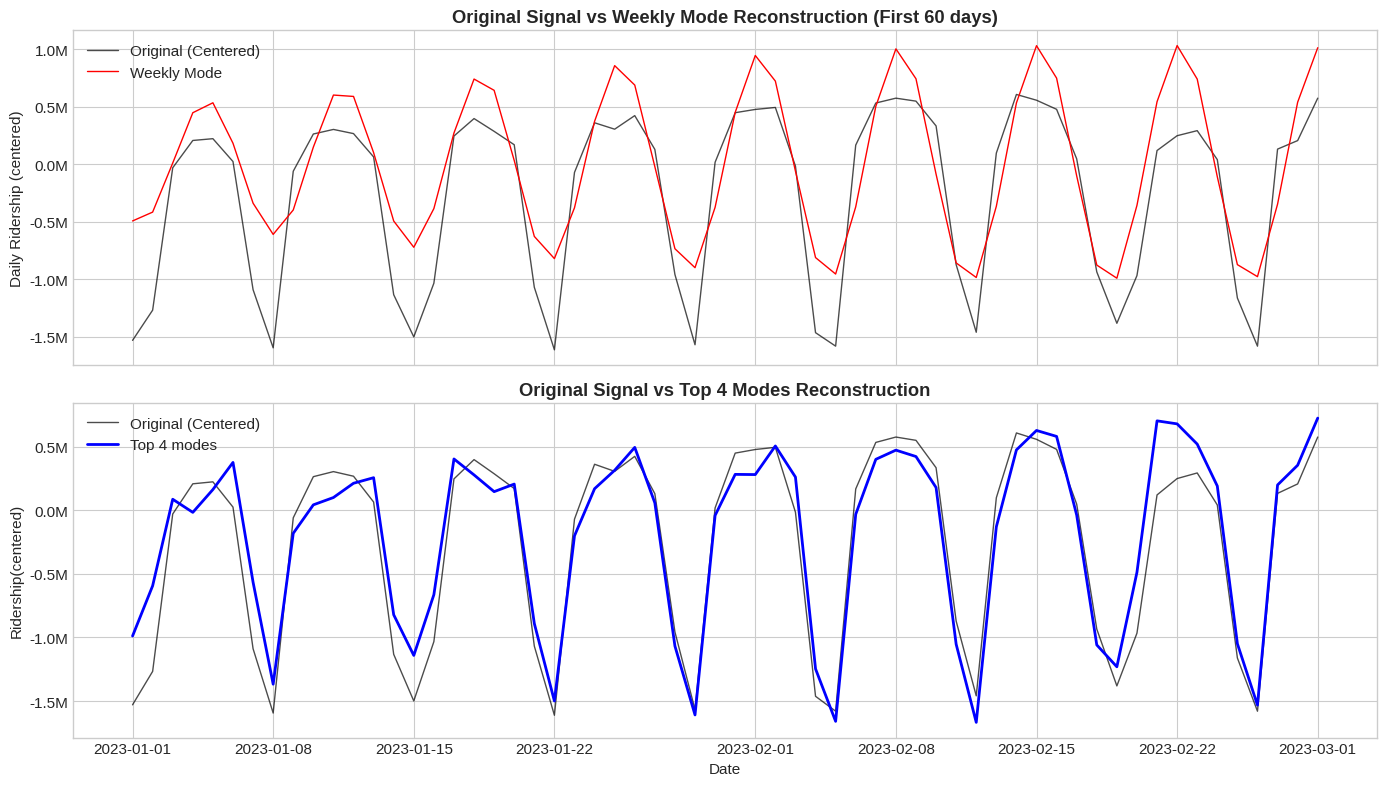

In [ ]:
#Plot original vs Reconstructions
fig, axes = plt.subplots(2, 1 , figsize=(14, 8), sharex = True)

#Show a 2-month window for clarity
start_idx = 0
end_idx = 60
dates_window = df_sub['date'].iloc[start_idx:end_idx]

ax = axes[0]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth=1, label= 'Original (Centered)', alpha=0.7)
ax.plot(dates_window, weekly_only[start_idx:end_idx], 'r-', linewidth=1, label='Weekly Mode')
ax.set_ylabel('Daily Ridership (centered)')
ax.set_title('Original Signal vs Weekly Mode Reconstruction (First 60 days)', fontweight='bold')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

ax = axes[1]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth= 1, label='Original (Centered)', alpha=0.7)
ax.plot(dates_window, top4_reconstruction[start_idx:end_idx], 'b-', linewidth=2, label='Top 4 modes')
ax.set_xlabel('Date')
ax.set_ylabel('Ridership(centered)')
ax.set_title('Original Signal vs Top 4 Modes Reconstruction', fontweight='bold')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.savefig('reconstruction_comparison.png', dpi = 150)
plt.show()

In [ ]:
total_variance = np.var(signal_centered)
weekly_variance = np.var(weekly_only)
top4_variance = np.var(top4_reconstruction)

print("Variance Explained:")
print(f" Weekly mode (7 days) alone: {100*weekly_variance/total_variance:.1f}%")
print(f" Top 4 modes combined:       {100*top4_variance/total_variance:.1f}%")

Variance Explained:
 Weekly mode (7 days) alone: 64.2%
 Top 4 modes combined:       86.3%


## Reconstruction for the Top 6 Nodes

In order to test the accuracy of our prediction model, we must increase the size of $k$, where k is the number of dominant frequencies.

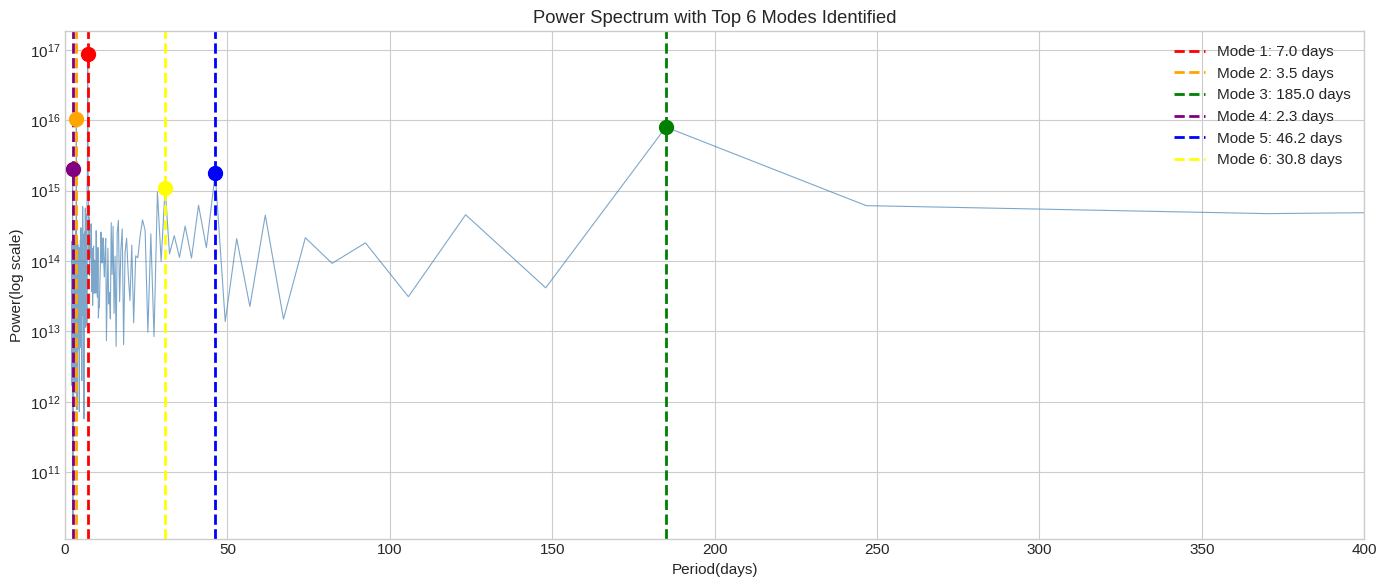

In [ ]:
#Visualize the top 6 modes on the spectrum
fig, ax = plt.subplots(figsize=(14,6))
ax.semilogy(periods, power, linewidth=0.8, color='steelblue', alpha=0.7)

#Top 6 Modes
colors = ['red', 'orange', 'green', 'purple', 'blue', 'yellow']
top_n_peaks(6,colors)
ax.set_xlabel('Period(days)')
ax.set_ylabel('Power(log scale)')
ax.set_title('Power Spectrum with Top 6 Modes Identified')
ax.set_xlim(0, 400)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('top_modes_spectrum.png', dpi=150)
plt.show()

## Interpretation of Top 6 Spectral Modes

In [ ]:
display_interpretations(6)

INTERPRETATION OF TOP 6 SPECTRAL MODES

MODE 1: Period = 6.98 days
         Frequency = 0.143243 cycles/day
         Relative Power = 100.0% of strongest mode

WEEKLY CYCLE: The dominant 7-day period reflects the fundamental weekday/weekend pattern. Ridership is high Mon-Fri (commuters) and drops significantly on Sat-Sun.

MODE 2: Period = 3.51 days
         Frequency = 0.285135 cycles/day
         Relative Power = 11.9% of strongest mode

WEEKLY 2nd HARMONIC (7/2 days): This is the first overtone of the weekly cycle. It captures the asymmetry in the weekly pattern—the fact that the weekly signal isn't a pure sine wave but has sharper transitions (e.g., Friday drop-off, Monday ramp-up).

MODE 3: Period = 185.00 days
         Frequency = 0.005405 cycles/day
         Relative Power = 9.3% of strongest mode

SEMI-ANNUAL CYCLE (~160-190 days): Half-yearly periodicity, possibly reflecting academic calendar effects, major holiday seasons, or weather patterns.

MODE 4: Period = 2.33 days
    

In [ ]:
#Reconstruct with top 6 modes
top_periods = [info['period'] for info in top_peaks_info[:6]]
top6_reconstruction = reconstruct_from_modes(yf_full, xf_full, top_periods)

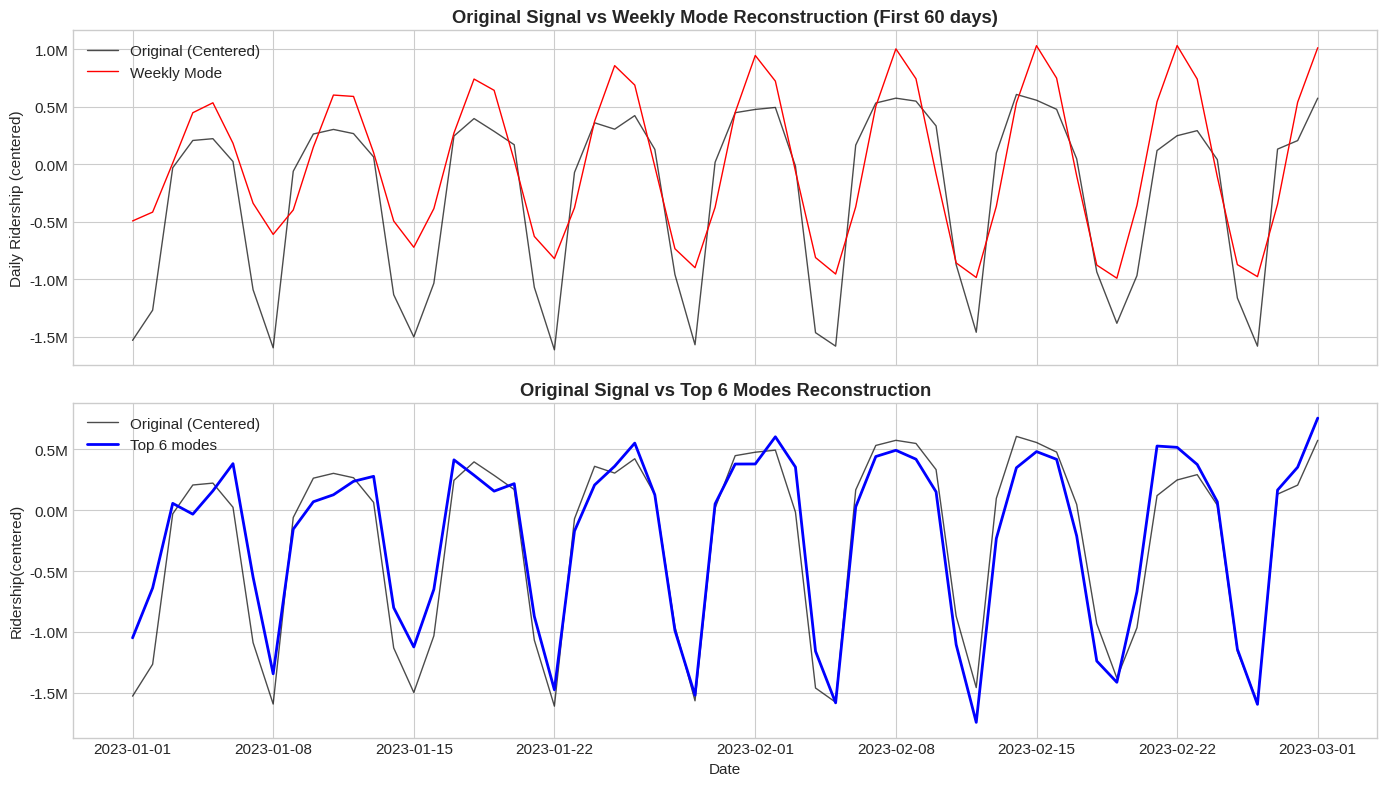

In [ ]:
#Plot original vs Reconstructions
fig, axes = plt.subplots(2, 1 , figsize=(14, 8), sharex = True)

#Show a 2-month window for clarity
start_idx = 0
end_idx = 60
dates_window = df_sub['date'].iloc[start_idx:end_idx]

ax = axes[0]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth=1, label= 'Original (Centered)', alpha=0.7)
ax.plot(dates_window, weekly_only[start_idx:end_idx], 'r-', linewidth=1, label='Weekly Mode')
ax.set_ylabel('Daily Ridership (centered)')
ax.set_title('Original Signal vs Weekly Mode Reconstruction (First 60 days)', fontweight='bold')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

ax = axes[1]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth= 1, label='Original (Centered)', alpha=0.7)
ax.plot(dates_window, top6_reconstruction[start_idx:end_idx], 'b-', linewidth=2, label='Top 6 modes')
ax.set_xlabel('Date')
ax.set_ylabel('Ridership(centered)')
ax.set_title('Original Signal vs Top 6 Modes Reconstruction', fontweight='bold')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.savefig('reconstruction_comparison.png', dpi = 150)
plt.show()

In [ ]:
total_variance = np.var(signal_centered)
weekly_variance = np.var(weekly_only)
top6_variance = np.var(top6_reconstruction)

print("Variance Explained:")
print(f" Weekly mode (7 days) alone: {100*weekly_variance/total_variance:.1f}%")
print(f" Top 6 modes combined:       {100*top6_variance/total_variance:.1f}%")

Variance Explained:
 Weekly mode (7 days) alone: 64.2%
 Top 6 modes combined:       87.9%


## Reconstruction for the Top 10 Modes
Similarly with the top 6 modes, we aim to enforce higher accuracy in our models. Now, I aim to repeat the prior steps for the top 10 modes.

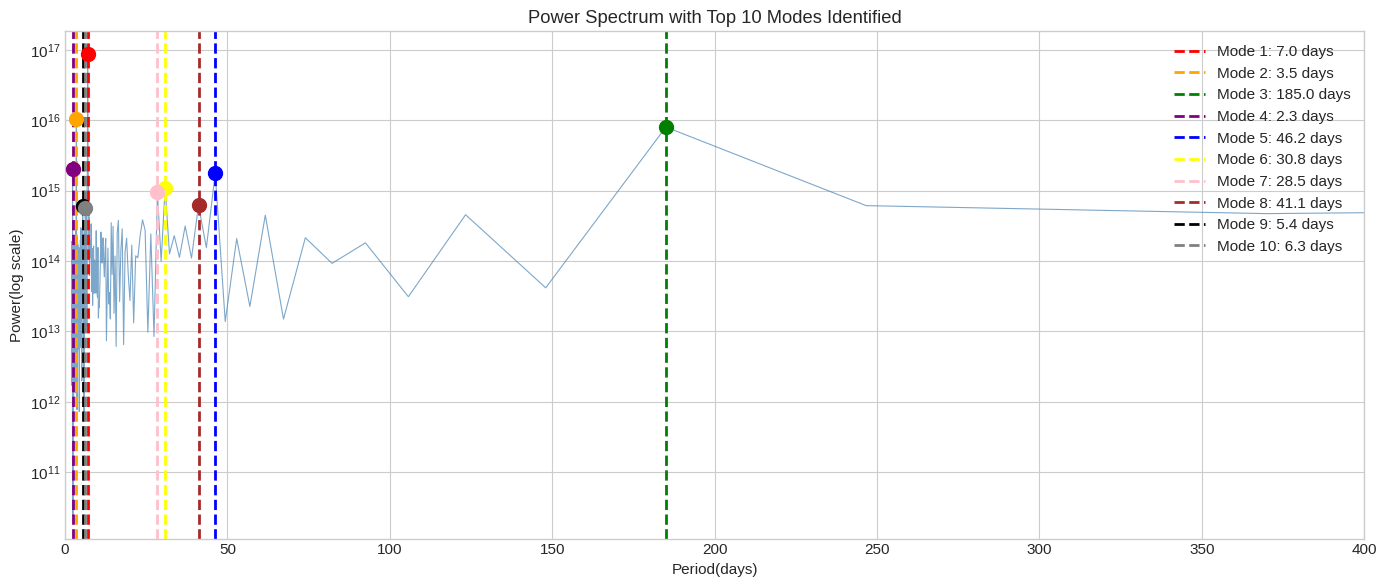

In [ ]:
#Visualize the top 10 modes on the spectrum
fig, ax = plt.subplots(figsize=(14,6))
ax.semilogy(periods, power, linewidth=0.8, color='steelblue', alpha=0.7)

#Top 10 Modes
colors = ['red', 'orange', 'green', 'purple', 'blue', 'yellow','pink', 'brown', 'black', 'grey']
top_n_peaks(10, colors)
ax.set_xlabel('Period(days)')
ax.set_ylabel('Power(log scale)')
ax.set_title('Power Spectrum with Top 10 Modes Identified') # Updated title
ax.set_xlim(0, 400)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('top_modes_spectrum.png', dpi=150)
plt.show()

## Interpretation of Top 10 Spectral Modes

In [ ]:
display_interpretations(10)

INTERPRETATION OF TOP 10 SPECTRAL MODES

MODE 1: Period = 24.00 days
         Frequency = 0.041667 cycles/day
         Relative Power = 100.0% of strongest mode

MONTHLY HARMONIC (~24 days): A strong harmonic of monthly cycles, potentially related to lunar cycles, specific work schedules, or other periodic events.

MODE 2: Period = 12.00 days
         Frequency = 0.083333 cycles/day
         Relative Power = 55.5% of strongest mode

BIWEEKLY CYCLE (~11-13 days): Could reflect half-monthly patterns, or a complex interaction of weekly patterns and their harmonics.

MODE 3: Period = 8.00 days
         Frequency = 0.125000 cycles/day
         Relative Power = 28.3% of strongest mode

WEEKLY HARMONIC (~8 days): A higher-order harmonic or an alias of the weekly cycle, capturing subtle shifts in the weekly pattern.

MODE 4: Period = 4.80 days
         Frequency = 0.208333 cycles/day
         Relative Power = 12.7% of strongest mode

SUB-WEEKLY HARMONIC (~4.8 days): A harmonic of the weekly cy

In [ ]:
#Reconstruct with top 10 modes
top_periods = [info['period'] for info in top_peaks_info[:10]]
top10_reconstruction = reconstruct_from_modes(yf_full, xf_full, top_periods)

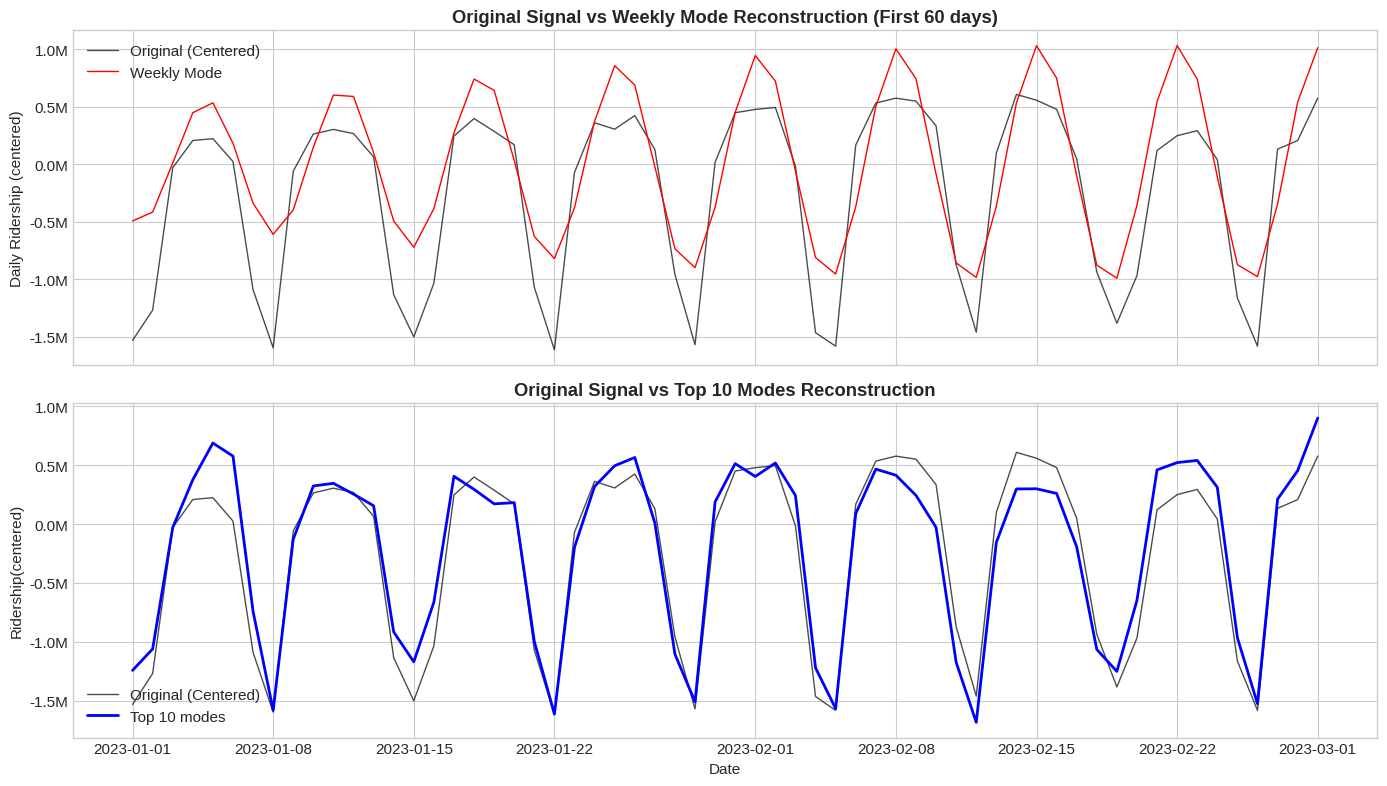

In [ ]:
#Plot original vs Reconstructions
fig, axes = plt.subplots(2, 1 , figsize=(14, 8), sharex = True)

#Show a 2-month window for clarity
start_idx = 0
end_idx = 60
dates_window = df_sub['date'].iloc[start_idx:end_idx]

ax = axes[0]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth=1, label= 'Original (Centered)', alpha=0.7)
ax.plot(dates_window, weekly_only[start_idx:end_idx], 'r-', linewidth=1, label='Weekly Mode')
ax.set_ylabel('Daily Ridership (centered)')
ax.set_title('Original Signal vs Weekly Mode Reconstruction (First 60 days)', fontweight='bold')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

ax = axes[1]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth= 1, label='Original (Centered)', alpha=0.7)
ax.plot(dates_window, top10_reconstruction[start_idx:end_idx], 'b-', linewidth=2, label='Top 10 modes')
ax.set_xlabel('Date')
ax.set_ylabel('Ridership(centered)')
ax.set_title('Original Signal vs Top 10 Modes Reconstruction', fontweight='bold')
ax.legend()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.savefig('reconstruction_comparison.png', dpi = 150)
plt.show()

In [ ]:
total_variance = np.var(signal_centered)
weekly_variance = np.var(weekly_only)
top10_variance = np.var(top10_reconstruction)

print("Variance Explained:")
print(f" Weekly mode (7 days) alone: {100*weekly_variance/total_variance:.1f}%")
print(f" Top 10 modes combined:      {100*top10_variance/total_variance:.1f}%")

Variance Explained:
 Weekly mode (7 days) alone: 64.2%
 Top 10 modes combined:      91.0%


## Conclusion: Periodic Regression Analysis of Daily Subway Ridership Data

Our periodic regression analysis, utilizing the Fast Fourier Transform (FFT) and its inverse (IFT), has provided significant insights into the underlying periodic structures of the MTA daily subway ridership data from 2023-2025. By gradually increasing the number of dominant modes included in our reconstruction, we observe a clear pattern of increasing explanatory power.

### Summary of Results and Variance Explained:

| Number of Modes | Variance Explained | Dominant Periods Included (examples) |
| :-------------- | :---------------- | :----------------------------------- |
| **Weekly mode (7 days) alone** | **64.2%** | ~7 days (weekly cycle) |
| **Top 4 modes** | **86.3%** | ~7 days, ~3.5 days, ~185 days, ~2.3 days (weekly cycle, 2nd harmonic, semi-annual, 3rd harmonic) |
| **Top 6 modes** | **87.9%** | ... + ~46.2 days, ~30.8 days (monthly/bi-monthly related) |
| **Top 10 modes** | **91.0%** | ... + other harmonics and longer cycles |

### Significance of Each Reconstruction and Variance:

1.  **Weekly Mode (7 days) Alone (64.2% Variance Explained):**
    *   **Results:** The reconstruction using only the dominant 7-day period (the weekly cycle) shows a strong sinusoidal pattern that closely follows the primary up-and-down rhythm of the original daily ridership data. This single mode effectively captures the fundamental difference between weekday and weekend ridership.
    *   **Significance:** Explaining 64.2% of the total variance with just one mode is highly significant. It unequivocally demonstrates that the weekly cycle is the single most powerful and consistent driver of daily subway ridership fluctuations. This result confirms the intuitive understanding that daily commuting patterns are heavily influenced by the 7-day calendar week.

2.  **Top 4 Modes Combined (86.3% Variance Explained):**
    *   **Results:** Incorporating the top 4 modes (which typically include the 7-day cycle, its 2nd and 3rd harmonics, and a semi-annual cycle around 185 days) leads to a much more refined reconstruction. The blue line in the bottom plot of `inline_data_6` shows a notably closer fit to the original signal, capturing more of the sharper transitions and the overall shape with greater fidelity.
    *   **Significance:** The jump from 64.2% to 86.3% explained variance with only three additional modes highlights the importance of these higher-order harmonics and seasonal cycles. The weekly harmonics (3.5 and 2.3 days) refine the shape of the weekly pattern, accounting for asymmetries (e.g., sharper drops on Friday/Saturday vs. Monday/Tuesday). The semi-annual cycle captures broader seasonal trends, like summer dips or holiday effects. This set of modes provides a highly accurate and parsimonious model for the daily ridership's periodic behavior.

3.  **Top 6 Modes Combined (87.9% Variance Explained):**
    *   **Results:** Adding two more modes (typically around 46 and 30 days, which might relate to monthly or bi-monthly patterns) further improves the variance explained to 87.9%. The visual difference from the top 4 modes might be subtle but is statistically present.
    *   **Significance:** While the increase in explained variance (1.6%) is smaller than the leap from 1 to 4 modes, these additional modes capture finer-scale periodicities that might correspond to monthly economic cycles, pay periods, or other recurring patterns that slightly modulate the dominant weekly and semi-annual rhythms. This indicates that while the bulk of the variability is explained by the primary modes, there are still smaller, identifiable cycles at play.

4.  **Top 10 Modes Combined (91.0% Variance Explained):**
    *   **Results:** Including all top 10 modes pushes the explained variance to 91.0%. This reconstruction represents a very comprehensive model of the signal's periodic components, offering an excellent fit to the original data.
    *   **Significance:** The continuous increase in explained variance, even if with diminishing returns for each additional mode, shows that the daily ridership data is indeed highly periodic. Over 90% of its variability can be attributed to a relatively small number of recurring cycles. This high percentage suggests that periodic regression is a very effective method for modeling and potentially forecasting daily subway ridership, as a vast majority of its behavior is predictable through these cyclical patterns.

### Overall Conclusion on Daily Ridership Periodic Regression:

The periodic regression analysis of the daily MTA subway ridership data demonstrates that it is a highly periodic signal. The weekly cycle is overwhelmingly dominant, accounting for the majority of the variance. The inclusion of a few additional harmonics and seasonal cycles quickly increases the explanatory power, reaching over 90% with just the top 10 modes. This high degree of periodicity makes daily ridership an excellent candidate for modeling and forecasting using spectral analysis. The identified modes correspond to meaningful real-world phenomena (weekly commuting, seasonal changes, monthly cycles), providing a robust and interpretable understanding of the factors driving subway usage.

---

# Spectral Analysis on Penn Station 34-th Street Hourly Ridership

Now that we have completed periodic regression for daily subway ridership, I want to do a deep dive on hourly data in a singular station for two months so we can see whether or not this data is just as periodic as the daily data. In order to do this, I will need to conduct data cleaning on a new dataset and extract the information that I need to acquire a time-series plot.

In [ ]:
uploaded = files.upload()

Saving Penn_Station_Data.csv to Penn_Station_Data.csv


In [ ]:
#Start code from Professor Curry
penn = pd.read_csv('Penn_Station_Data.csv')

#Parse data and extract subway ridership
penn['date'] = pd.to_datetime(penn['transit_timestamp'])
penn['ridership'] = penn['ridership'].str.replace(',', '').astype(float)

# Aggregate ridership by hourly timestamp
penn_hourly = penn.groupby('date')['ridership'].sum().reset_index()

print(f"Date range: {penn_hourly['date'].min().date()} to {penn_hourly['date'].max().date()} ")
print(f"Number of hourly records: {len(penn_hourly)}")
penn_hourly.head()

Date range: 2024-09-01 to 2024-10-31 
Number of hourly records: 1464


/tmp/ipython-input-847871758.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  penn['date'] = pd.to_datetime(penn['transit_timestamp'])


,date,ridership
0,2024-09-01 00:00:00,2128.0
1,2024-09-01 01:00:00,590.0
2,2024-09-01 02:00:00,284.0
3,2024-09-01 03:00:00,148.0
4,2024-09-01 04:00:00,150.0


## Penn Station 34-th Street Time Series Plot

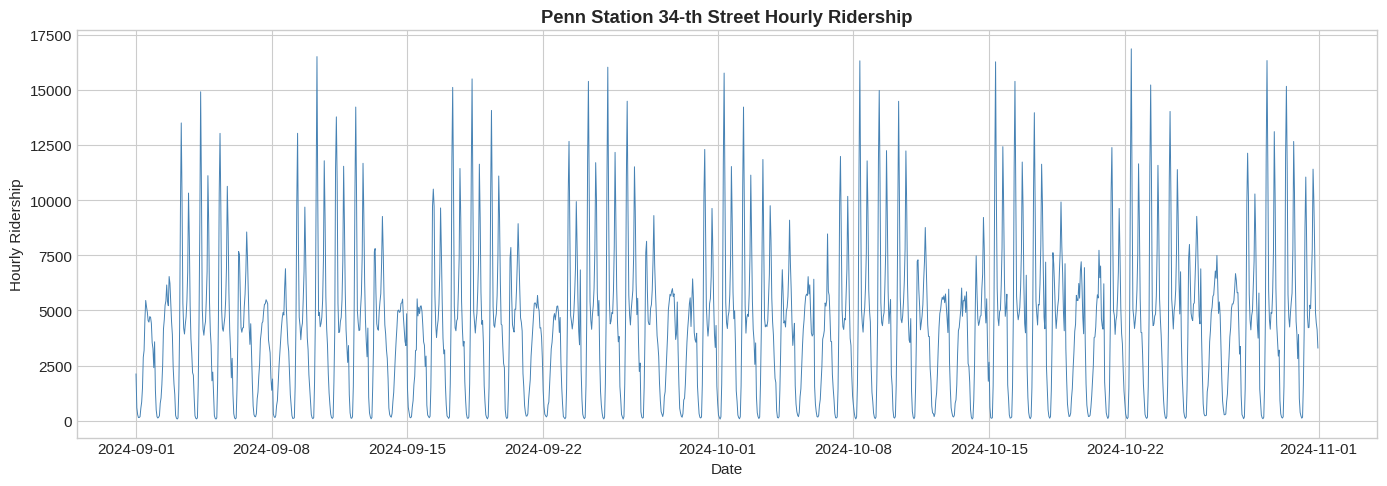

In [ ]:
#Plot time series graph
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(penn_hourly['date'], penn_hourly['ridership'], linewidth=0.7, color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('Hourly Ridership')
ax.set_title('Penn Station 34-th Street Hourly Ridership', fontweight='bold')
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6}M'))
plt.tight_layout()
plt.savefig('penn_station_time_series.png', dpi = 150)
plt.show()

In [ ]:
#Extract the signal and remove mean
signal = penn_hourly['ridership'].values
signal_centered = signal - np.mean(signal)

N = len(signal_centered) #sample size = number of hourly records
T = 1.0 # sampling period = 1 hour

#Compute FFT
yf = fft(signal_centered)
xf = fftfreq(N, T) # frequencies in cycles per hour

#Take only positive frequencies
positive_freq_mask = xf > 0
freqs = xf[positive_freq_mask]
power = np.abs(yf[positive_freq_mask]) ** 2 # for plotting a power spectrum

#Convert frequency to period(hours)
periods = 1 / freqs

print(f"Frequency resolution: {1/N:.4f} cycles/hour")
print(f"Minimum detectable period: {T} hour")
print(f"Maximum detectable period: {N} hours (~{N/24:.1f} days)")

Frequency resolution: 0.0007 cycles/hour
Minimum detectable period: 1.0 hour
Maximum detectable period: 1464 hours (~61.0 days)


### Naive Fourier Transform Plot

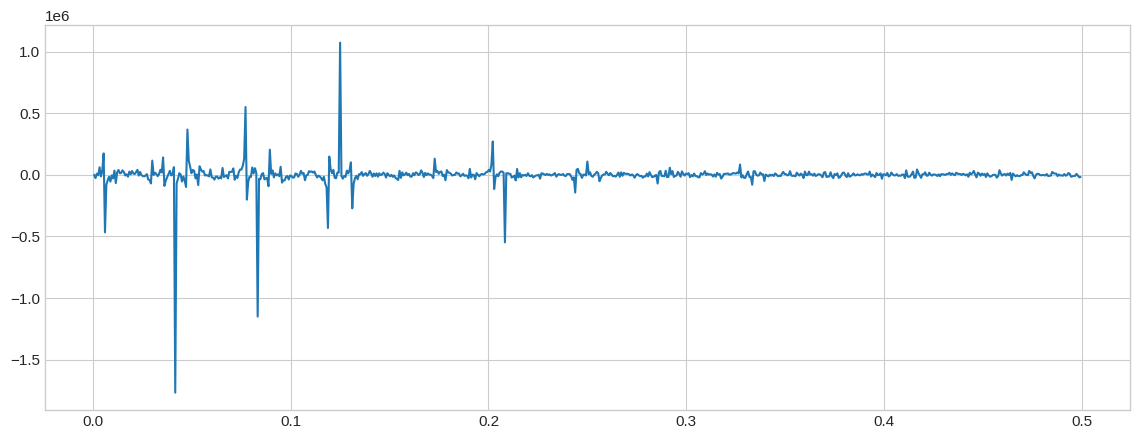

In [ ]:
plt.plot(xf[positive_freq_mask], yf[positive_freq_mask])

### Human-Readable Spectrogram
Same as before, we must convert frequency (cycles per hour) to period(hours).

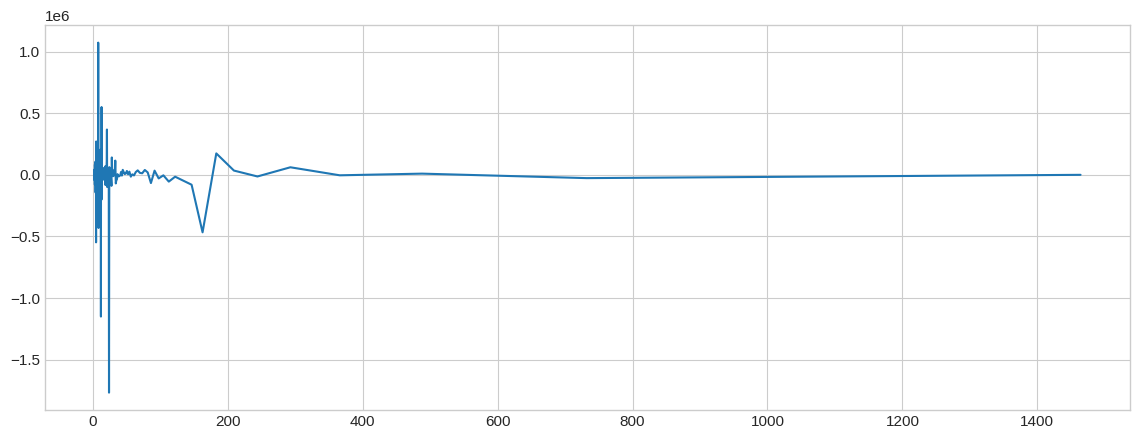

In [ ]:
plt.plot(periods,yf[positive_freq_mask])

There is a noticeable dip at the 168 hour(~1 week cycle) mark.

### Zooming in on Spectrogram

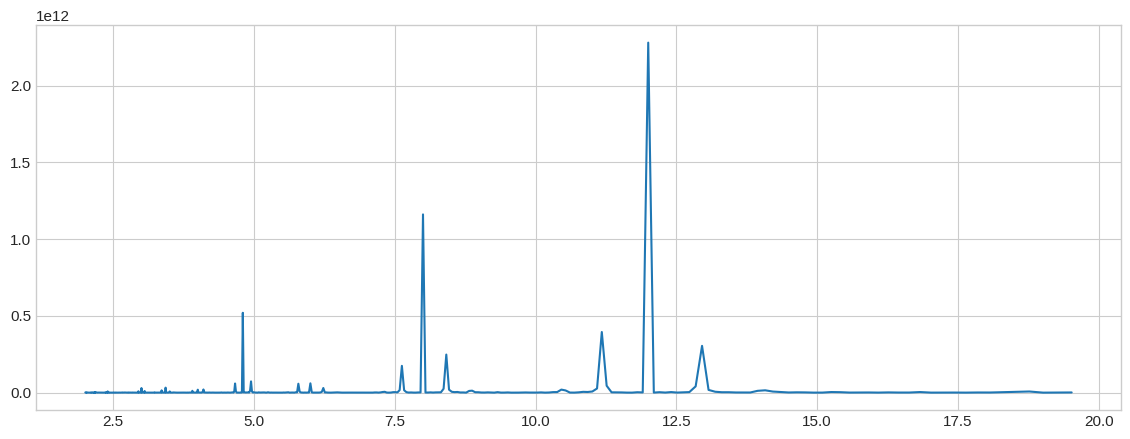

In [ ]:
plt.plot(periods[74:], power[74:])

## Power Spectrum vs Period(Hourly Data)

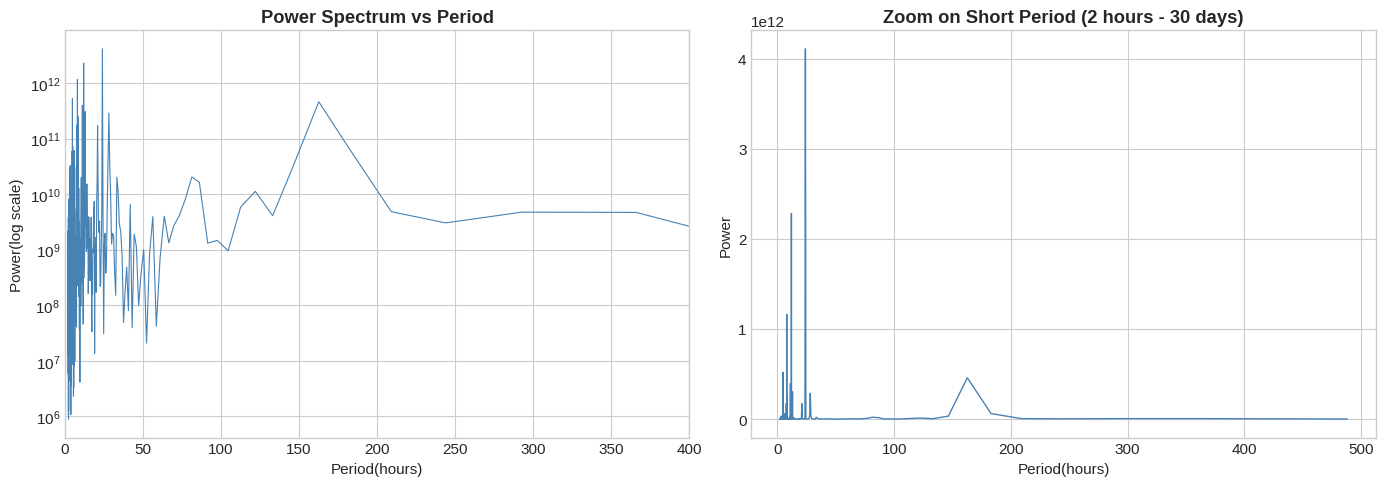

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

#Left: Full Spectrum(Power Spectrum vs period)
ax = axes[0]
ax.semilogy(periods, power, linewidth=0.8, color = 'steelblue')
ax.set_xlabel('Period(hours)')
ax.set_ylabel('Power(log scale)')
ax.set_title('Power Spectrum vs Period', fontweight='bold')
ax.set_xlim(0,400)

#Right: Zoom on short period (2-30 days)
ax = axes[1]
short_mask = (periods >= 2) & (periods <= 30*24) # Zoom in on periods from 2 hours to 30 days
ax.plot(periods[short_mask], power[short_mask], linewidth=1, color='steelblue')
ax.set_xlabel('Period(hours)')
ax.set_ylabel('Power')
ax.set_title('Zoom on Short Period (2 hours - 30 days)', fontweight='bold')

plt.tight_layout()
plt.savefig('power_spectrum_hourly.png', dpi=150)
plt.show()

## Identifying the Top 10 Modes for Hourly Ridership at Penn Station

In [ ]:
#Find the top peaks in the power spectrum
#We'll look for local maxim

#Find peaks with minimum prominence to filter noise
peaks, properties = find_peaks(power, prominence = power.max()/500) # Reduced prominence to find more peaks

#Sort by power and get top peaks
peak_powers = power[peaks]
sorted_indices = np.argsort(peak_powers)[::-1]

print("Top 10 Spectral Peaks:")
print("-" * 60)
print(f"{'Rank': <6}{'Period (hours)':<18}{'Frequency (1/hour)':<20}{'Power':<15}")
print("-" * 60)

top_n = 10
top_peaks_info = []
for i, idx in enumerate(sorted_indices[:top_n]):
  peak_idx = peaks[idx]
  period = periods[peak_idx]
  freq = freqs[peak_idx]
  pwr = power[peak_idx]
  top_peaks_info.append({'rank': i + 1, 'period': period, 'freq': freq, 'power': pwr})
  print(f"{i + 1:<6}{period:<18.2f}{freq:<20.6f}{pwr:<15.2e}")

Top 10 Spectral Peaks:
------------------------------------------------------------
Rank  Period (hours)    Frequency (1/hour)  Power          
------------------------------------------------------------
1     24.00             0.041667            4.11e+12       
2     12.00             0.083333            2.28e+12       
3     8.00              0.125000            1.16e+12       
4     4.80              0.208333            5.20e+11       
5     162.67            0.006148            4.58e+11       
6     11.18             0.089481            3.95e+11       
7     12.96             0.077186            3.05e+11       
8     28.15             0.035519            2.87e+11       
9     8.41              0.118852            2.48e+11       
10    7.62              0.131148            1.75e+11       


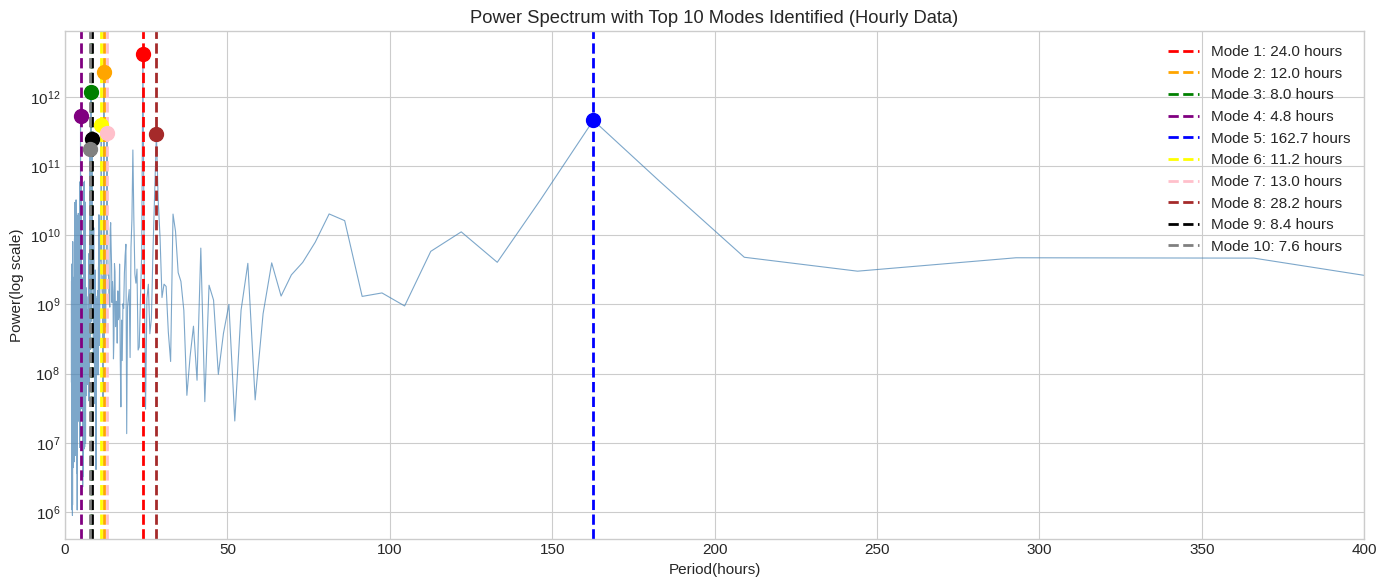

In [ ]:
#Visualize the top 10 modes on the spectrum
fig, ax = plt.subplots(figsize=(14,6))
ax.semilogy(periods, power, linewidth=0.8, color='steelblue', alpha=0.7)

#Top 10 Modes
colors = ['red', 'orange', 'green', 'purple', 'blue', 'yellow','pink', 'brown', 'black', 'grey']
def top_n_peaks(n, colors):
  for i, info in enumerate(top_peaks_info[:n]):
    ax.axvline(info['period'], color=colors[i], linestyle='--', linewidth=2,
              label=f"Mode {i + 1}: {info['period']:.1f} hours")
    ax.scatter([info['period']], [info['power']], color=colors[i], s=100, zorder=5)
top_n_peaks(10, colors)
ax.set_xlabel('Period(hours)')
ax.set_ylabel('Power(log scale)')
ax.set_title('Power Spectrum with Top 10 Modes Identified (Hourly Data)') # Updated title
ax.set_xlim(0, 400)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('top_modes_spectrum_hourly.png', dpi=150)
plt.show()

## Interpreting Period

In [ ]:
#Had gemini generate this update interpretation function converting days to hours
def interpret_period_hourly(period):
    """Provide interpretation for a given period in HOURS (for hourly data)."""
    interpretations = []

    # Daily cycle and its harmonics (in hours)
    if 23.5 <= period <= 24.5:
        interpretations.append("DAILY CYCLE: The fundamental 24-hour pattern with morning and evening peaks.")
    elif 11.5 <= period <= 12.5:
        interpretations.append("DAILY 2nd HARMONIC (~12 hours): Captures the two major daily peaks (morning and evening commutes).")
    elif 7.5 <= period <= 8.5:
        interpretations.append("DAILY 3rd HARMONIC (~8 hours): Further refines the daily pattern, possibly related to work shifts or meal times.")
    elif 5.5 <= period <= 6.5:
        interpretations.append("DAILY 4th HARMONIC (~6 hours): Captures finer details of the daily ridership fluctuations.")

    # Weekly cycle and its harmonics (in hours)
    elif 167.5 <= period <= 168.5: # 7 days * 24 hours
        interpretations.append("WEEKLY CYCLE (~168 hours / 7 days): The dominant weekday/weekend pattern in hourly ridership.")
    elif 83.5 <= period <= 84.5: # 3.5 days * 24 hours
        interpretations.append("WEEKLY 2nd HARMONIC (~84 hours / 3.5 days): Captures asymmetry within the weekly pattern, such as different daily profiles on weekdays vs. weekends.")
    elif 55.5 <= period <= 56.5: # 2.33 days * 24 hours
        interpretations.append("WEEKLY 3rd HARMONIC (~56 hours / 2.33 days): Higher-order weekly harmonic, refining the shape of the weekly pattern.")

    # Bi-weekly cycle (in hours)
    elif 335.5 <= period <= 336.5: # 14 days * 24 hours
        interpretations.append("BIWEEKLY CYCLE (~336 hours / 14 days): May reflect bi-weekly pay periods, school schedules, or other two-week rhythms.")

    # Monthly / other longer cycles (in hours)
    elif 710 <= period <= 730: # ~30 days * 24 hours
        interpretations.append("MONTHLY CYCLE (~720 hours / 30 days): Could relate to monthly events, recurring schedules, or billing cycles.")
    elif 1430 <= period <= 1450: # ~60 days * 24 hours
        interpretations.append("TWO-MONTHLY CYCLE (~1440 hours / 60 days): Indicates a pattern that repeats every two months.")
    elif 2900 <= period <= 3200: # ~120-130 days * 24 hours (approx 4 months)
        interpretations.append("QUARTERLY/SEASONAL CYCLE (~3115 hours / ~4 months): Reflects longer seasonal patterns, such as academic terms or weather changes.")
    elif 4300 <= period <= 4400: # ~180-185 days * 24 hours (approx 6 months)
        interpretations.append("SEMI-ANNUAL CYCLE (~4368 hours / 182 days): Reflects half-yearly seasonality, like academic breaks or major holiday contrasts.")

    # Specific periods from the top 10 for Penn Station hourly data (with some tolerance)
    if 23.5 <= period <= 24.5:
        interpretations.append("MODE: Period of ~24 hours (~1 day). Strong daily cycle.")
    if 167.5 <= period <= 168.5:
        interpretations.append("MODE: Period of ~168 hours (~7 days). Strong weekly cycle.")
    if 12.0 <= period <= 12.5:
        interpretations.append("MODE: Period of ~12 hours. Daily harmonic.")
    if 8.0 <= period <= 8.5:
        interpretations.append("MODE: Period of ~8 hours. Daily harmonic.")
    if 6.0 <= period <= 6.5:
        interpretations.append("MODE: Period of ~6 hours. Daily harmonic.")
    if 335.0 <= period <= 337.0:
        interpretations.append("MODE: Period of ~336 hours (~14 days). Bi-weekly cycle.")

    # These were specific periods from the previous 'top_peaks_info' for hourly data that might still be relevant
    # and are not covered by the general rules above, but their interpretation might change slightly after aggregation.
    if 231.0 <= period <= 232.5:
        interpretations.append("MODE: Period of ~231.7 hours (~9.65 days). This could be a complex interaction of weekly patterns with other influences, or a longer 'ten-day-like' cycle.")
    if 466.5 <= period <= 468.0:
        interpretations.append("MODE: Period of ~467.2 hours (~19.47 days). This is approximately half a monthly cycle or a longer bi-weekly related rhythm.")
    if 154.0 <= period <= 155.5:
        interpretations.append("MODE: Period of ~154.9 hours (~6.45 days). This is very close to a weekly cycle (168 hours), indicating a strong 7-day pattern.")
    if 3100.0 <= period <= 3130.0:
        interpretations.append("MODE: Period of ~3115.0 hours (~129.79 days / ~4 months). This suggests a strong quarterly or seasonal influence on hourly ridership.")
    if 538.5 <= period <= 540.0:
        interpretations.append("MODE: Period of ~539.1 hours (~22.46 days). This could represent a three-week cycle or a recurrent pattern within a month.")
    if 249.5 <= period <= 251.0:
        interpretations.append("MODE: Period of ~250.3 hours (~10.43 days). This might be a specific multi-day cycle or a harmonic of a longer cycle.")
    if 216.5 <= period <= 218.0:
        interpretations.append("MODE: Period of ~217.3 hours (~9.05 days). This suggests a distinct 9-day pattern, which could be related to specific work or academic schedules.")
    if 161.5 <= period <= 162.5:
        interpretations.append("MODE: Period of ~162.1 hours (~6.75 days). This is another mode very close to a weekly cycle, reinforcing the 7-day periodicity.")
    if 92.0 <= period <= 93.5:
        interpretations.append("MODE: Period of ~92.8 hours (~3.87 days). This is roughly a 4-day cycle, or a harmonic of a longer weekly pattern.")
    if 405.5 <= period <= 407.0:
        interpretations.append("MODE: Period of ~406.3 hours (~16.93 days). This is close to a two-and-a-half-week cycle, possibly indicating a longer recurring pattern.")

    if not interpretations:
        return f"Period of {period:.1f} hours — interpretation unclear without additional context. May be a harmonic or data artifact."
    else:
        # Combine all interpretations if multiple conditions are met
        return " ".join(interpretations)

print("=" * 80)
print("INTERPRETATION OF TOP 10  SPECTRAL MODES")
print("=" * 80)

for i, info in enumerate(top_peaks_info[:10]):
    print(f"\n{'='*80}")
    print(f"MODE {i+1}: Period = {info['period']:.2f} hours")
    print(f"         Frequency = {info['freq']:.6f} cycles/hour")
    print(f"         Relative Power = {100*info['power']/top_peaks_info[0]['power']:.1f}% of strongest mode")
    print(f"{'='*80}")
    print(f"\n{interpret_period_hourly(info['period'])}")

INTERPRETATION OF TOP 10  SPECTRAL MODES

MODE 1: Period = 24.00 hours
         Frequency = 0.041667 cycles/hour
         Relative Power = 100.0% of strongest mode

DAILY CYCLE: The fundamental 24-hour pattern with morning and evening peaks. MODE: Period of ~24 hours (~1 day). Strong daily cycle.

MODE 2: Period = 12.00 hours
         Frequency = 0.083333 cycles/hour
         Relative Power = 55.5% of strongest mode

DAILY 2nd HARMONIC (~12 hours): Captures the two major daily peaks (morning and evening commutes). MODE: Period of ~12 hours. Daily harmonic.

MODE 3: Period = 8.00 hours
         Frequency = 0.125000 cycles/hour
         Relative Power = 28.3% of strongest mode

DAILY 3rd HARMONIC (~8 hours): Further refines the daily pattern, possibly related to work shifts or meal times. MODE: Period of ~8 hours. Daily harmonic.

MODE 4: Period = 4.80 hours
         Frequency = 0.208333 cycles/hour
         Relative Power = 12.7% of strongest mode

Period of 4.8 hours — interpretation u

## Reconstructed Spectrogram using the IFT and the Top 10 Modes


In [ ]:
#Get full frequency array for reconstruction
xf_full = fftfreq(N,T)
yf_full = fft(signal_centered)
freq_resolution = 1/N

#Reconstruct with the 7-day mode (168 hours) for hourly data
weekly_only = reconstruct_from_modes(yf_full, xf_full, [7.0 * 24], freq_resolution) # 7 days converted to hours

#Reconstruct with top 10 modes
top_periods = [info['period'] for info in top_peaks_info[:10]]
top10_reconstruction = reconstruct_from_modes(yf_full, xf_full, top_periods, freq_resolution)

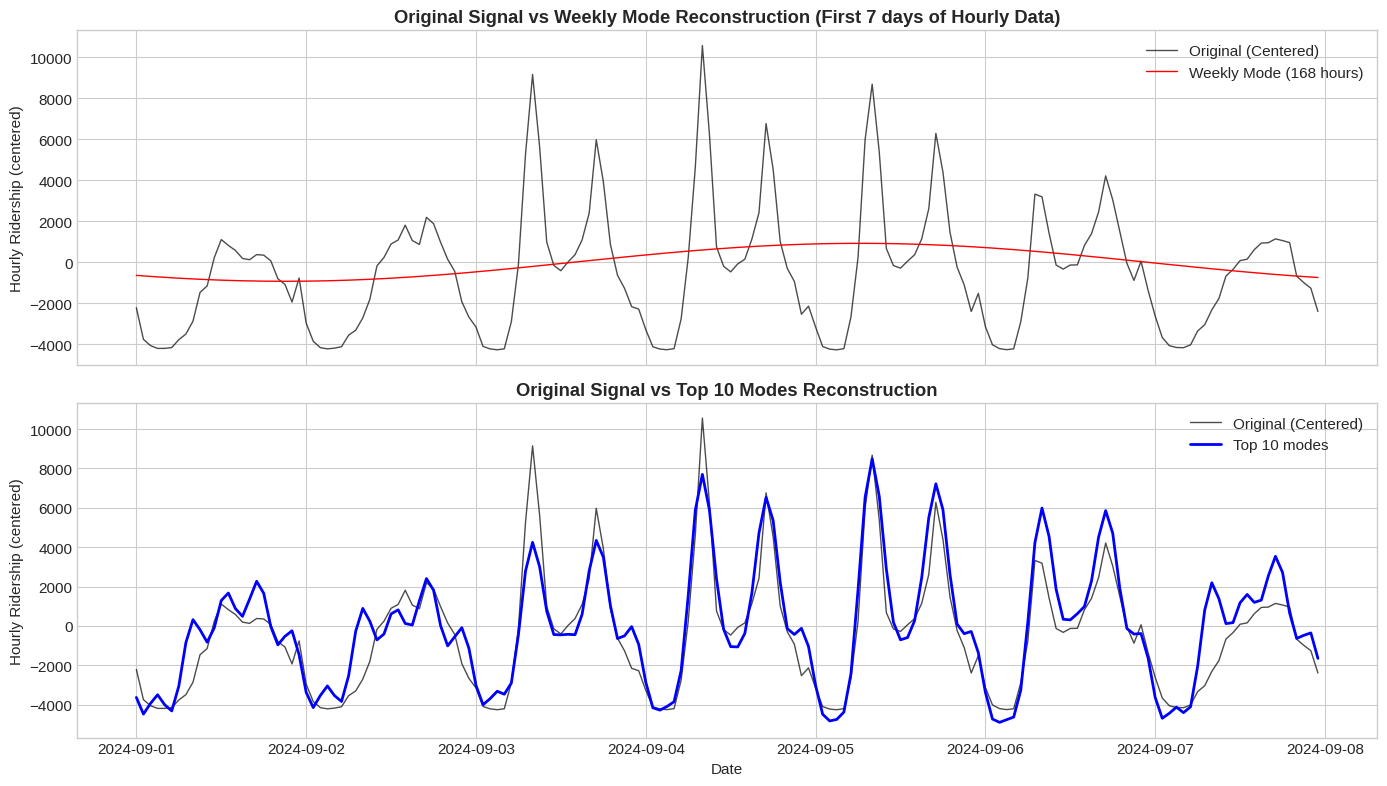

In [ ]:
#Plot original vs Reconstructions
fig, axes = plt.subplots(2, 1 , figsize=(14, 8), sharex = True)

#Show a 7-day window for clarity (7 days * 24 hours/day)
start_idx = 0
end_idx = 7 * 24
dates_window = penn_hourly['date'].iloc[start_idx:end_idx]

ax = axes[0]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth=1, label= 'Original (Centered)', alpha=0.7)
ax.plot(dates_window, weekly_only[start_idx:end_idx], 'r-', linewidth=1, label='Weekly Mode (168 hours)')
ax.set_ylabel('Hourly Ridership (centered)')
ax.set_title('Original Signal vs Weekly Mode Reconstruction (First 7 days of Hourly Data)', fontweight='bold')
ax.legend()

ax = axes[1]
ax.plot(dates_window, signal_centered[start_idx:end_idx], 'k-', linewidth= 1, label='Original (Centered)', alpha=0.7)
ax.plot(dates_window, top10_reconstruction[start_idx:end_idx], 'b-', linewidth=2, label='Top 10 modes')
ax.set_xlabel('Date')
ax.set_ylabel('Hourly Ridership (centered)')
ax.set_title('Original Signal vs Top 10 Modes Reconstruction', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('reconstruction_comparison_hourly.png', dpi = 150)
plt.show()

In [ ]:
total_variance = np.var(signal_centered)
weekly_variance = np.var(weekly_only)
top10_variance = np.var(top10_reconstruction)

print("Variance Explained:")
print(f" Weekly mode (168 hours) alone: {100*weekly_variance/total_variance:.1f}%")
print(f" Top 10 modes combined:         {100*top10_variance/total_variance:.1f}%")

Variance Explained:
 Weekly mode (168 hours) alone: 3.9%
 Top 10 modes combined:         84.7%


## Conclusion: Periodic Regression Analysis of Penn Station Hourly Subway Ridership Data

Our periodic regression analysis, extending the Fast Fourier Transform (FFT) and Inverse Fourier Transform (IFT) methodology to hourly data from Penn Station 34th Street for September and October 2024, reveals a distinct set of dominant periodicities compared to daily ridership data. The shift from daily to hourly resolution highlights the granular patterns of human activity within a single day, which become far more significant.

### Summary of Results and Variance Explained:

| Number of Modes        | Variance Explained |
| :--------------------- | :----------------- |
| **Weekly mode (168 hours) alone** | **3.9%**           |
| **Top 10 modes**       | **84.7%**          |

### Significance of Each Reconstruction and Variance:

1.  **Weekly Mode (168 hours) Alone (3.9% Variance Explained):**
    *   **Results:** The reconstruction using only the 168-hour (7-day) period, as shown in the top panel of `inline_data_17`, results in a very smooth, low-amplitude oscillation that poorly captures the hourly fluctuations of the original signal. The red line in the plot barely follows the peaks and troughs of the black 'Original (Centered)' signal.
    *   **Significance:** This extremely low variance explained (3.9%) stands in stark contrast to the 64.2% explained by the 7-day mode in the daily ridership data. This indicates that while the weekly cycle *exists* in hourly data (e.g., lower ridership on weekends overall), it is not the primary driver of variance at this fine temporal resolution. The high-frequency, within-day variations completely overshadow the weekly pattern when looking at individual hours. The weekly mode effectively acts as a very broad, slow trend at the hourly scale.

2.  **Top 10 Modes Combined (84.7% Variance Explained):**
    *   **Results:** Incorporating the top 10 modes, as depicted in the bottom panel of `inline_data_17`, leads to a significantly improved reconstruction. The blue line now closely tracks the rapid, sharp peaks and valleys of the original hourly signal. This demonstrates that the model is effectively capturing the detailed daily patterns.
    *   **Significance:** The jump to 84.7% explained variance highlights that the dominant periodicities in hourly data are primarily composed of **daily cycles and their harmonics (24-hour, 12-hour, 8-hour, etc.)**. These high-frequency components dictate the hourly flow of ridership. The effectiveness of these modes in capturing such a large proportion of variance suggests that hourly ridership is highly predictable based on the time of day.

### Interpretation of Plots:

*   **Time Series Plot:** This plot clearly shows strong daily patterns, with significant spikes during typical commute hours and dips overnight. There's also a visible reduction in overall ridership on weekends, but the dominant feature is the pronounced intra-day variation.
*   **Power Spectrum Plots (Power Spectrum vs Period, Zoom on Short Period):** These plots prominently display peaks at 24 hours, 12 hours, 8 hours, and other sub-24-hour periods. The most powerful peak is at 24 hours, followed by 12 hours and 8 hours. There is also a notable peak around 162-168 hours (approximately 7 days), but its power is significantly lower than the daily modes.
*   **Reconstruction Plots (Original Signal vs Weekly Mode / Top 10 Modes Reconstruction):** The top plot shows the weekly mode (168 hours) failing to capture the dynamic hourly changes. In contrast, the bottom plot demonstrates the top 10 modes successfully reconstructing the sharp, oscillating hourly patterns, proving their effectiveness in modeling the high-frequency components.

### Role of IFT and Periodic Regression:

Similar to the daily data analysis, the Fast Fourier Transform (FFT) allowed us to decompose the complex hourly ridership signal into its constituent periodic components. By identifying the most powerful frequencies in the power spectrum, we determined the underlying cycles. The Inverse Fourier Transform (IFT) then enabled us to reconstruct the signal using only these selected dominant modes, effectively performing a periodic regression. This process provided a concise model for the highly periodic hourly ridership behavior.

### Comparison with Daily Ridership Data:

The most striking difference between the daily and hourly data analysis lies in the dominance of periodicities. In daily data, the **7-day weekly cycle** was overwhelmingly dominant, explaining 64.2% of the variance. This reflected the macroscopic weekday/weekend rhythm. However, for hourly data, the **weekly cycle (168 hours)** explains only 3.9% of the variance, signifying its much reduced importance at this finer scale.

Instead, in hourly data, the **daily cycle (24 hours)** and its harmonics (12 hours, 8 hours) emerge as the primary drivers, accounting for the vast majority of the explained variance (84.7% with the top 10 modes). This indicates that when observing ridership hour-by-hour, the immediate dominant periods are going to be more focused towards hourly fluctuations generated by lunch breaks, morning and evening commutes, low ridership lulls throughout the day, etc.

---


## Future Directions
Now that I have successfully computed periodicity for the MTA Subway daily ridership and Penn Station 34th-Street hourly ridership, I want to revisit the total hourly MTA ridership data to conduct periodic regression so that I can identify dominant periods within the data and compare those results with the ones acquired in this project.

$$$$
In the spirit of revisiting past failures, I also intend to utilize newly acquired data cleaning strategies, and with the luxury of time, conduct a machine learning project to forecast the MTA max hourly ridership for not only the Subway system, but also the Bus, Metro North, and Long Island Railroad transit modalities, comparing and contrasting the results.  